In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
traindata = pd.read_csv("train.csv")
testdata = pd.read_csv("test.csv")
traindata.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Obviously there is a need to drop "PassengerId" and "Name" columns because they do not affect "Survived" column

In [3]:
traindata.drop(["PassengerId", "Name"], axis = 1, inplace = True)
traindata.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S


Due to the ratio between count of Cabin NaNs and count of rows may be it is optimal to drop Cabin to improve model quality. But we will try that later

In [ ]:
print(traindata.shape)
traindata.isnull().sum()


The volume of unique values of ticket column is too huge, perhaps it does not contain core information:

In [4]:
traindata = traindata.drop("Ticket", axis = 1)

Applying one-hot encoding for columns with string values, nans and int categorical marks:

In [5]:
columns_to_encode = ["Sex", "Cabin", "Embarked"]

In [6]:
trainencoded = pd.concat([pd.get_dummies(traindata[columns_to_encode], dummy_na = True), traindata.drop(columns_to_encode, axis =1)], axis = 1)

In [ ]:
trainencoded

No outliers detected:

In [ ]:
traindata.describe()

Age column contains NaN values. Replacing with mean age:

In [7]:
trainencoded["Age"].fillna(trainencoded["Age"].mean(), inplace = True)

<h4> Concerning correlations between values:</h4>

SibSp has high correlation with Parch and Fare level correlates positively with probabilyty to survive:

In [ ]:
corr = trainencoded[trainencoded.columns[-6:161]].corr()
sns.heatmap(corr, annot = True)

T-SNE reveals some pattern using for these columns: Survived,	Pclass,	 Age,	SibSp,	Parch,	Fare

In [10]:
from sklearn.manifold import TSNE
compressed = TSNE(n_components=2, learning_rate=10, min_grad_norm = 0.0005,
init='random', n_jobs = 4).fit_transform(trainencoded[trainencoded.columns[-6:161]])
tsne_ds = pd.concat([traindata["Survived"], pd.DataFrame(compressed)], axis = 1)

<AxesSubplot:xlabel='0', ylabel='1'>

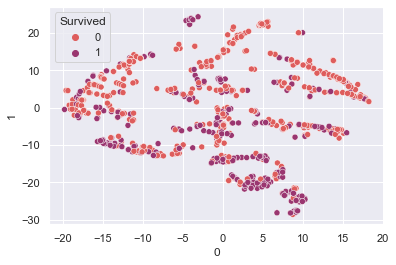

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
palette = sns.color_palette("flare",2)
sns.set_theme(palette = palette)
f, ax = plt.subplots()
sns.scatterplot(data = tsne_ds, x = 0, y = 1, hue = "Survived")

Trying the same but with all columns. Some pattern still exist, it means that the SVM has potential for applying models

<AxesSubplot:xlabel='0', ylabel='1'>

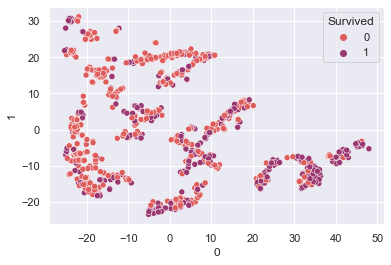

In [12]:
compressed_all = TSNE(n_components=2, learning_rate=10, min_grad_norm = 0.00005,
init='random', n_jobs = 4).fit_transform(trainencoded)
tsne_ds_all = pd.concat([traindata["Survived"], pd.DataFrame(compressed_all)], axis = 1)
sns.scatterplot(data = tsne_ds_all, x = 0, y = 1, hue = "Survived")

Applying Random Forest Classifier:

Create split for test data and train data:

In [8]:
from sklearn.model_selection import train_test_split
xtrain = trainencoded.drop(["Survived"], axis = 1)
ytrain = trainencoded["Survived"]
X_train, X_test, y_train, y_test = train_test_split(xtrain, ytrain, test_size =  0.2, random_state = 42)

Finding best parameters for Random Forest:
(Warning! Evaluation of next cell will take nearly 15 minutes)

In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier


preds = []
for ftr in range(10, 80, 10):
    for est in range(3, 200, 50):
        for splt in range(5, 20, 2):
            for dp in range(3, 20, 2):
                model = RandomForestClassifier(max_features = ftr/100, n_estimators = est, min_samples_split = splt, max_depth = dp, n_jobs = 6)
                model.fit(X_train, y_train)
                scores = cross_val_score(model, X_train, y_train, cv=4)
                preds.append({"score":np.median(scores), "max_features":ftr/100, "n_estimators":est, "min_samples_split":splt, "depth":dp})
p = sorted(preds, key = lambda item: item["score"])

+1/16 +1/16 +1/16 +1/16 +1/16 +1/16 +1/16 +1/16 +1/16 +1/16 +1/16 +1/16 +1/16 +1/16 +1/16 +1/16 +1/16 +1/16 +1/16 +1/16 +1/16 +1/16 +1/16 +1/16 +1/16 +1/16 +1/16 +1/16 

The mvp-best parameters for Random Forest

In [18]:
print(p[-1])

{'score': 0.8426966292134832, 'max_features': 0.5, 'n_estimators': 103, 'min_samples_split': 5, 'depth': 17}


2016

This is how the Random Forest progress looks like. There were lots of of parameters that give the same score:

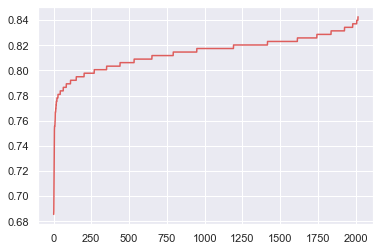

In [21]:
xlin = [i for i in range(1, len(p)+1)]
ylin = [p[i]["score"] for i in range(len(p))]
plt.plot(xlin, ylin)

Try to heuristically find amount of estimators but with better accuracy:

In [39]:
estims = p[-1]["n_estimators"]
preds = []
for est in range(estims-50, estims+50):
    model = RandomForestClassifier(max_features = 0.5, n_estimators = est, min_samples_split = 5, max_depth = 17, n_jobs = 6)
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X_train, y_train, cv=4)
    preds.append({"score":np.median(scores), "max_features":0.5, "n_estimators":est, "min_samples_split":5, "depth":17})
    
p = sorted(preds, key = lambda item: item["score"])
print(p[-1])

{'score': 0.8461538461538461, 'max_features': 0.5, 'n_estimators': 118, 'min_samples_split': 5, 'depth': 17}


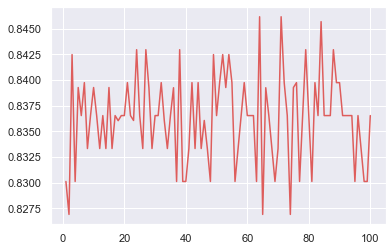

In [40]:
xlin = [i for i in range(1, len(preds)+1)]
ylin = [preds[i]["score"] for i in range(len(preds))]
plt.plot(xlin, ylin)

This estimator count parameters may be used for ensembling forest models:

In [43]:
best_estims = [p[i]["n_estimators"] for i in range(len(p)) if p[i]["score"]>0.8435 ]
best_estims

[131, 111, 118]

Cross Validation with K-Fold method:
P.S. The predictions are based on the X-axis, and the true values situated on the Y-axis on the heatmap.

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       105
           1       0.85      0.70      0.77        74

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.82       179



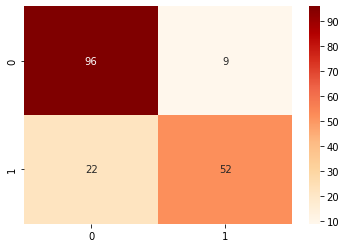

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import seaborn as sns
model = RandomForestClassifier(max_features = 0.5, n_estimators = 103, min_samples_split = 5, max_depth = 17)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
#display = ConfusionMatrixDisplay(conf_matrix)
#display.plot()
sns.heatmap(conf_matrix, annot=True,cmap="OrRd")
print(classification_report(y_test, y_pred))


Roc-auc score reveals that model separates classes quite good

In [17]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])


0.8772200772200772

Cross-validation with 4 sample-packs. The score varies significantly depending on a particular sample-pack

In [23]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train, y_train, cv=4)
print(f'Minimum score: {min(scores)}, Maximum score: {max(scores)}')
print(*scores)
print(f"The median score is: {np.median(scores)}")

Minimum score: 0.8089887640449438, Maximum score: 0.8651685393258427
0.8089887640449438 0.8651685393258427 0.8202247191011236 0.8595505617977528
The median score is: 0.8398876404494382


Estimation of feature importances according to Random Forest model:

<AxesSubplot:>

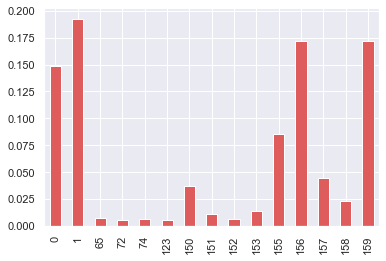

In [28]:
imp = model.feature_importances_
forest_importances = pd.Series(imp)
best_columns = xtrain.columns[forest_importances[forest_importances>0.140].index]
forest_importances[forest_importances>0.005].plot.bar()

The most important features:

<AxesSubplot:>

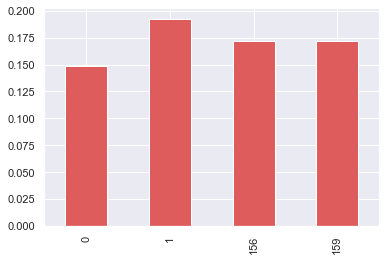

In [29]:
forest_importances[forest_importances>0.100].plot.bar()

Sex, Age and Fare give the most powerful impact:

In [30]:
print(*best_columns.values)

Sex_female Sex_male Age Fare


Applying SVC model using cross-validation:

In [31]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
X_train, X_test, y_train, y_test = train_test_split(xtrain, ytrain, test_size =  0.3, random_state = 42)


scores = []
for gamma in range(100, 500, 50):
    for toler in range(500, 5000, 250):
        clf = make_pipeline(StandardScaler(), SVC(cache_size = 2048, random_state = 42, gamma = 1/gamma, tol = 1/toler))
        score = np.median(cross_val_score(clf, X_train, y_train, cv = 4, n_jobs = 6))
        scores.append({"score":score, "gamma":1/gamma, "tol": 1/toler})


By changing gamma and tol parameters score fluctuates insignificantly from 0.77 to 0.78

In [32]:
x = sorted(scores, key = lambda item: item["score"], reverse = True)
print(f"The best result and parameters: {x[0]}")
print(f"The worst result: {x[-1]}")

The best result and parameters: {'score': 0.782051282051282, 'gamma': 0.01, 'tol': 0.002}
The worst result: {'score': 0.7756410256410255, 'gamma': 0.002857142857142857, 'tol': 0.0002105263157894737}


Applying K-neighbours Classifier and finding best parameters using cross validation in cicle:

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
predictions = []
for i in range(2, 500):
    neigh = KNeighborsClassifier(n_neighbors=i)
    score = np.median(cross_val_score(neigh, X_train, y_train, cv = 4, n_jobs = 6))
    predictions.append({"score":score, "n_neighbors":i})
x = sorted(predictions, key = lambda item: item["score"], reverse = True)
x[0]

{'score': 0.7202646815550041, 'n_neighbors': 5}

Score depending on amount of neighbors graph:

In [34]:
predictions_scores = [item["score"] for item in predictions]
nbrs = list(range(2, 500))

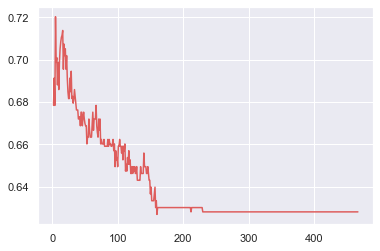

In [35]:
import matplotlib.pyplot as plt
plt.plot(nbrs, predictions_scores)

Finding the best parameters for Cat Boost Classifier with early stop. (AUC as a main metric):

Ratio of people who survived to death is 60:40. Profit may be gained by enabling "stratified" CatBoost option.

In [13]:
print(len(y_train) - sum(y_train))
268/444

268


0.6036036036036037

15 iterations of algorithm with learning rate = 0.1 is the best. Increasing of learning rate decreases amount of iterations needed, but rockets entropy of AUC. leraning rate 0.1 is probably the best. Stratifing slightly increasing results.

In [19]:
from catboost import CatBoostClassifier
from catboost import Pool
from catboost import cv
from sklearn.metrics import accuracy_score

pool = Pool(X_train, label = y_train)

params = {}
params['loss_function'] = 'Logloss'
params['early_stopping_rounds'] = 10
params['custom_loss'] = 'AUC'
params['random_seed'] = 42
params['learning_rate'] = 0.1
params['verbose'] = False
cv_data = cv(
    params = params,
    pool = pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    
)




MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.4205837283
bestIteration = 29

Training on fold [1/5]

bestTest = 0.441720311
bestIteration = 20

Training on fold [2/5]

bestTest = 0.3626672087
bestIteration = 70

Training on fold [3/5]

bestTest = 0.410084578
bestIteration = 55

Training on fold [4/5]

bestTest = 0.4356427096
bestIteration = 18



'model = CatBoostClassifier(\n    iterations = 300,\n    learning_rate = 0.1,\n    loss_function = "Logloss",\n    verbose = False,\n    eval_metric = "AUC",\n    early_stopping_rounds = 5\n)'

Training model with this parameters. However accuracy and AUC fluctuate insignificantly after 4-th iteration, logloss decreases steadily.

In [36]:
model = CatBoostClassifier(
    iterations = 13,
    learning_rate = 0.1,
    loss_function = "Logloss",
    verbose = False,
    eval_metric = "AUC",
    custom_loss = ["AUC", "Accuracy"]
    #early_stopping_rounds = 5
)
                            
                       
model.fit(X = pool, plot = True, eval_set = (X_test, y_test), verbose = False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [55]:
from typing import NoReturn
from typing import Any
def get_roc_score(model: CatBoostClassifier, X_test: pd.DataFrame, y_test: Any) -> NoReturn:
    from catboost.utils import get_fpr_curve
    from catboost.utils import get_fnr_curve
    from catboost.utils import get_roc_curve
    import matplotlib.pyplot as plt
    eval_pool = Pool(X_test, y_test)
    curve = get_roc_curve(model, data = eval_pool)
    (thresholds, fpr) = get_fpr_curve(model = model, curve = curve)
    (thresholds, fnr) = get_fnr_curve(model = model, curve = curve)
    plt.plot(thresholds, fpr, color = "blue")
    plt.plot(thresholds, fnr, color = "darkorange")
    plt.legend(["fpr", "fnr"])
    plt.xlabel("Threshold")
    
    
    
    
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import accuracy_score
    roc_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f"ROC-AUC score is {roc_score}")
    ac_score = accuracy_score(y_test, pred)
    print(f"Accuracy score is {ac_score}")

ROC-AUC score is 0.8874517374517376
Accuracy score is 0.8212290502793296


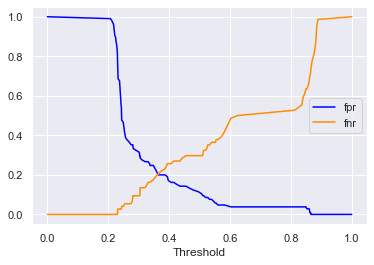

In [53]:
get_roc_score(X_test = X_test, y_test = y_test, model = model)